# Gaussian Naive Bayes

 Naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naive) independence assumptions between the features.

Illustration of how a Gaussian Naive Bayes (GNB) classifier works. For each data point, the z-score distance between that point and each class-mean is calculated, namely the distance from the class mean divided by the standard deviation of that class. Note that this schematic just shows one dimension, whereas a crucial distinction between GNBs and other classifiers arises only when there is more than one input dimension: the GNB does not model the covariance between dimensions, but other types of classifier do.

![Naive Bayes](datasets/naivebayes.png)

In [1]:
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm, neighbors
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [2]:
train_split = 0.80
nrows = 30_000_000
path = 'c:/users/ugy1/abs/'
df=pd.read_csv(path+'datasets/processed_abs_loan_'+str(nrows)+'.csv', 
               #usecols=use_list, 
               #sep='\t',
               #compression=bz2,
               nrows=nrows,
               low_memory=False, 
              index_col=0, 
               parse_dates=True,

              )
df.shape

(26199370, 109)

In [3]:
column_list=df.columns.tolist()

In [4]:
df.head()

,originalloanamount,originalloanterm,originalinterestratepercentage,graceperiodnumber,obligorcreditscore,paymenttoincomepercentage,reportingperiodbeginningloanbalanceamount,nextreportingperiodpaymentamountdue,reportingperiodinterestratepercentage,nextinterestratepercentage,...,"zerobalance_[""1""]","zerobalance_[""3""]","zerobalance_[""4""]",S&P/Experian Auto Default Index,AutoIndex,BankCardIndex,FirstMortgageIndex,SecondMortgageIndex,CompositeIndex,label
2016-12-31,19339.41,60.0,5.39,0.0,710.0,0.0682,18818.87,369.25,5.39,5.39,...,0,0,0,0.0106,1.06,3.21,0.72,0.48,0.92,0.0
2016-12-31,17955.27,60.0,8.99,1.0,654.0,0.0792,17779.76,373.97,8.99,8.99,...,0,0,0,0.0106,1.06,3.21,0.72,0.48,0.92,0.0
2016-12-31,14815.00,72.0,9.55,0.0,707.0,0.0372,14518.87,542.22,9.55,9.55,...,0,0,0,0.0106,1.06,3.21,0.72,0.48,0.92,1.0
2016-12-31,13186.31,60.0,9.90,1.0,622.0,0.0488,13048.32,0.00,9.90,9.90,...,0,0,0,0.0106,1.06,3.21,0.72,0.48,0.92,0.0
2016-12-31,16400.00,48.0,10.90,0.0,656.0,0.0829,16182.14,845.98,10.90,10.90,...,0,0,0,0.0106,1.06,3.21,0.72,0.48,0.92,1.0


In [5]:
# prepare label for scikit-learn
Y=df.label.values
Y.shape

(26199370,)

In [6]:
# prepare input data for scikit-learn
input=df.values
input.shape

(26199370, 109)

In [7]:
# calculate train/test split

len_train = int(len(input)*train_split)
print(len_train)

20959496


In [8]:
# apply train/test split to labels
y_train = Y[0:len_train]
y_test = Y[len_train:]
x_train = input[0:len_train]
x_test = input[len_train:]
x_train.shape

(20959496, 109)

In [9]:
export_x_test = pd.DataFrame(data=x_test)

In [10]:
export_x_test.columns=column_list
export_x_test.rename(columns={'label':'True Label'}, inplace=True)
export_x_test.head()

,originalloanamount,originalloanterm,originalinterestratepercentage,graceperiodnumber,obligorcreditscore,paymenttoincomepercentage,reportingperiodbeginningloanbalanceamount,nextreportingperiodpaymentamountdue,reportingperiodinterestratepercentage,nextinterestratepercentage,...,"zerobalance_[""1""]","zerobalance_[""3""]","zerobalance_[""4""]",S&P/Experian Auto Default Index,AutoIndex,BankCardIndex,FirstMortgageIndex,SecondMortgageIndex,CompositeIndex,True Label
0,12187.00,62.0,0.0385,2.0,802.0,0.03450,8962.82,0.00,0.0385,0.0385,...,0.0,0.0,0.0,0.0097,0.96,3.56,0.63,0.59,0.86,0.0
1,18656.42,62.0,0.0190,2.0,734.0,0.04080,14165.76,326.45,0.0190,0.0190,...,0.0,0.0,0.0,0.0097,0.96,3.56,0.63,0.59,0.86,0.0
2,9679.13,50.0,0.0000,2.0,753.0,0.02370,7460.98,201.65,0.0000,0.0000,...,0.0,0.0,0.0,0.0097,0.96,3.56,0.63,0.59,0.86,0.0
3,22000.00,73.0,0.0424,1.0,792.0,0.03928,2729.91,346.60,0.0424,0.0424,...,0.0,0.0,0.0,0.0097,0.96,3.56,0.63,0.59,0.86,0.0
4,16366.35,61.0,0.0190,1.0,736.0,0.06240,570.68,285.18,0.0190,0.0190,...,0.0,0.0,0.0,0.0097,0.96,3.56,0.63,0.59,0.86,0.0


In [11]:
#from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import minmax_scale
# from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import QuantileTransformer
# from sklearn.preprocessing import PowerTransformer

In [12]:
x_scaler=StandardScaler()
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.fit_transform(x_test)

In [13]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
clf_gnb = gnb.fit(x_train, y_train)
confidence_gnb=clf_gnb.score(x_test, y_test)

In [14]:
x_pred = x_test

In [15]:
prediction_gnb = clf_gnb.predict(x_pred)

In [16]:
export_x_test['Predicted Label']=prediction_gnb

In [17]:
export_x_test.head()

,originalloanamount,originalloanterm,originalinterestratepercentage,graceperiodnumber,obligorcreditscore,paymenttoincomepercentage,reportingperiodbeginningloanbalanceamount,nextreportingperiodpaymentamountdue,reportingperiodinterestratepercentage,nextinterestratepercentage,...,"zerobalance_[""3""]","zerobalance_[""4""]",S&P/Experian Auto Default Index,AutoIndex,BankCardIndex,FirstMortgageIndex,SecondMortgageIndex,CompositeIndex,True Label,Predicted Label
0,12187.00,62.0,0.0385,2.0,802.0,0.03450,8962.82,0.00,0.0385,0.0385,...,0.0,0.0,0.0097,0.96,3.56,0.63,0.59,0.86,0.0,0.0
1,18656.42,62.0,0.0190,2.0,734.0,0.04080,14165.76,326.45,0.0190,0.0190,...,0.0,0.0,0.0097,0.96,3.56,0.63,0.59,0.86,0.0,0.0
2,9679.13,50.0,0.0000,2.0,753.0,0.02370,7460.98,201.65,0.0000,0.0000,...,0.0,0.0,0.0097,0.96,3.56,0.63,0.59,0.86,0.0,0.0
3,22000.00,73.0,0.0424,1.0,792.0,0.03928,2729.91,346.60,0.0424,0.0424,...,0.0,0.0,0.0097,0.96,3.56,0.63,0.59,0.86,0.0,0.0
4,16366.35,61.0,0.0190,1.0,736.0,0.06240,570.68,285.18,0.0190,0.0190,...,0.0,0.0,0.0097,0.96,3.56,0.63,0.59,0.86,0.0,0.0


In [18]:
export_x_test.shape

(5239874, 110)

In [19]:
export_x_test.to_csv(path+"prediction/gnaivebayes/predicated_g_navie_bayes_abs_loans_"+str(nrows)+".csv", chunksize=10000)

In [20]:
def plot_confusion_matrix(cm, title, classes=['Non-Current', 'Current'],
                          cmap=plt.cm.Blues, save=False, saveas="MyFigure.png"):
    
    # print Confusion matrix with blue gradient colours
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(saveas, dpi=100)

In [21]:
def plot_gridsearch_cv(results, estimator, x_min, x_max, y_min, y_max,save=False, saveas="MyFigure.png"):
    
    # print GridSearch cross-validation for parameters
    
    plt.figure(figsize=(10,8))
    plt.title("GridSearchCV for "+estimator, fontsize=24)

    plt.xlabel(estimator)
    plt.ylabel("Score")
    plt.grid()

    ax = plt.axes()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    pad = 0.005
    X_axis = np.array(results["param_"+estimator].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['b', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score+pad))

    plt.legend(loc="best")
    plt.grid('off')
    plt.tight_layout()
    if save:
        plt.savefig(saveas, dpi=100)
        
    plt.show()

             precision    recall  f1-score   support

Non-Current       1.00      1.00      1.00   4454309
    Current       1.00      1.00      1.00    785565

avg / total       1.00      1.00      1.00   5239874

AUC:  100.0%


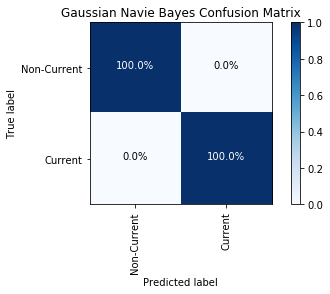

In [22]:
print(classification_report(y_test, prediction_gnb, target_names=['Non-Current', 'Current']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, prediction_gnb)))
cm = confusion_matrix(y_test, prediction_gnb)
plot_confusion_matrix(cm, title="Gaussian Navie Bayes Confusion Matrix",save=True, 
                      saveas='prediction/gnaivebayes/cm'+str(' Gaussian Naive Bayes Accuracy-')+str(nrows)+'.jpg')

ROC_AUC_SCORE ;  1.0
Confusion matrix, without normalization
[[4454309       0]
 [      0  785565]]


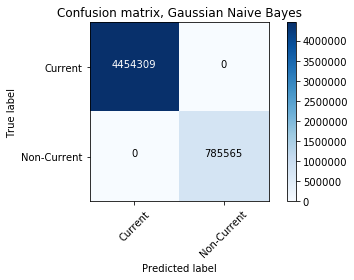

In [23]:
class_names = ['Current', 'Non-Current']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


print('ROC_AUC_SCORE ; ', roc_auc_score(y_test, prediction_gnb))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, prediction_gnb)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title= 'Confusion matrix, Gaussian Naive Bayes')
plt.savefig('prediction/gnaivebayes/cm'+str(' Gaussian Naive Bayes Prediction-')+str(nrows)+'.jpg')
plt.show()